#### Import the relavant packages

In [1]:
from torch_snippets import *
from torchvision import transforms as T
from torch.nn import functional as F
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#### Data preprocessing and processing functions

In [2]:
from torchvision.models import vgg19
preprocess = T.Compose([
                        T.ToTensor(),
                        T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
                        T.Lambda(lambda x: x.mul_(255))
                        ])

In [3]:
postprocess = T.Compose([
                T.Lambda(lambda x: x.mul_(1./255)),
                T.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225]),
])

#### Define the Gram matrix

In [4]:
class GramMatrix(nn.Module):
    def forward(self,input_image):
        b,c,h,w = input_image.size()
        features = input_image.view(b ,c, h*w)
        G = features@features.transpose(1,2)
        G.div_(h*w)
        return G

In [5]:
class GramMSELoss(nn.Module):
    def forward(self,input_image, target):
        output = F.mse_loss(GramMatrix()(input_image), target)

        return (output)

#### Define the model class, vgg19_modified

In [6]:
class VGG19Modified(nn.Module):
    def __init__(self):
        super(VGG19Modified, self).__init__()

        features = list(vgg19(pretrained=True).features)
        self.features = nn.ModuleList(features).eval()

    def forward(self, x, layers=[]):
        order = np.argsort(layers)
        _results, results = [], []
        for ix,model in enumerate(self.features):
            x = model(x)
            if ix in layers: _results.append(x)
        for o in order: results.append(_results[o])
        return results if layers is not [] else x

In [7]:
vgg = VGG19Modified().to(device)

/home/m294/anaconda3/envs/cv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/m294/anaconda3/envs/cv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### Import the content and style images

In [8]:
! wget https://www.dropbox.com/s/z1y0fy2r6z6m6py/60.jpg
! wget https://www.dropbox.com/s/1svdliljyo0a98v/style_image.png

--2023-08-06 18:16:25--  https://www.dropbox.com/s/z1y0fy2r6z6m6py/60.jpg
Resolving www.dropbox.com (www.dropbox.com)... 162.125.72.18, 2620:100:6027:18::a27d:4812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.72.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/z1y0fy2r6z6m6py/60.jpg [following]
--2023-08-06 18:16:25--  https://www.dropbox.com/s/raw/z1y0fy2r6z6m6py/60.jpg
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4f18972309536628b6594e77ed.dl.dropboxusercontent.com/cd/0/inline/CBQxCtEAnD30pk7ffRQfHgX9htlJWyT82gxd7kvmeYkBBKMSJILsnghDg5ZN6mIhmlhQUjg0ZzOiL03q1m8CBfX866DfJMcAkKYnjGj4fooad6rB_hGoZfPqwZb66YVODiE/file# [following]
--2023-08-06 18:16:26--  https://uc4f18972309536628b6594e77ed.dl.dropboxusercontent.com/cd/0/inline/CBQxCtEAnD30pk7ffRQfHgX9htlJWyT82gxd7kvmeYkBBKMSJILsnghDg5ZN6mIhmlhQUjg0ZzOiL03q1m8CBfX866DfJMcAkKYnjGj4fooad6rB_hGoZfPqwZb66YVODiE/file
R

In [9]:
imgs = [Image.open(path).resize((512,512)).convert('RGB') for path in ['style_image.png', '60.jpg']]

In [10]:
style_image,content_image=[preprocess(img).to(device)[None] for img in imgs]

In [11]:
opt_img = content_image.data.clone()
opt_img.requires_grad = True

In [12]:
style_layers = [0, 5, 10, 19, 28]
content_layers = [21]
loss_layers = style_layers + content_layers

In [13]:
loss_fns = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
loss_fns = [loss_fn.to(device) for loss_fn in loss_fns]

In [14]:
style_weights = [1000/n**2 for n in [64,128,256,512,512]]
content_weights = [1]
weights = style_weights + content_weights

In [15]:
style_targets = [GramMatrix()(A).detach() for A in vgg(style_image, style_layers)]
content_targets = [A.detach() for A in vgg(content_image, content_layers)]
targets = style_targets + content_targets

In [16]:
max_iters = 2500
optimizer = optim.LBFGS([opt_img])
log = Report(max_iters)

In [17]:
iters = 0
while iters < max_iters:
    def closure():
        global iters
        iters += 1
        optimizer.zero_grad()
        out = vgg(opt_img, loss_layers)
        layer_losses = [weights[a]*loss_fns[a](A,targets[a]) \
        for a,A in enumerate(out)]
        loss = sum(layer_losses)
        loss.backward()
        log.record(pos=iters, loss=loss, end='\r')
        return loss
    optimizer.step(closure)

EPOCH: 2502.000  loss: 3966494.750  (350.96s - -0.28s remaining))ng)

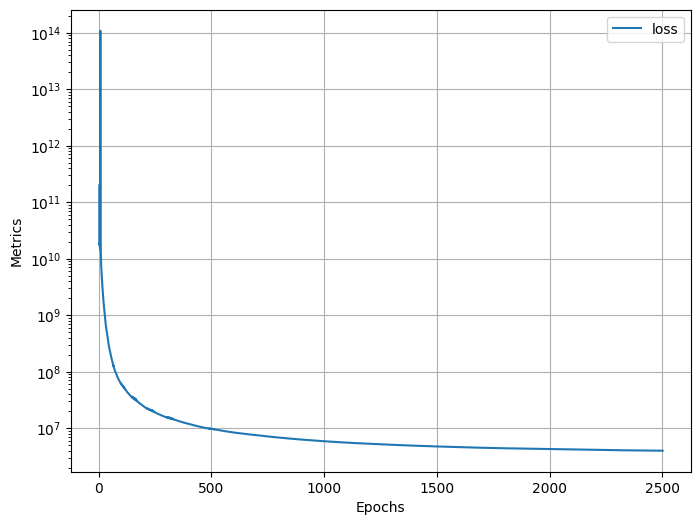

In [21]:
log.plot(log=True)

In [22]:
out_img = T.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225])(opt_img[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


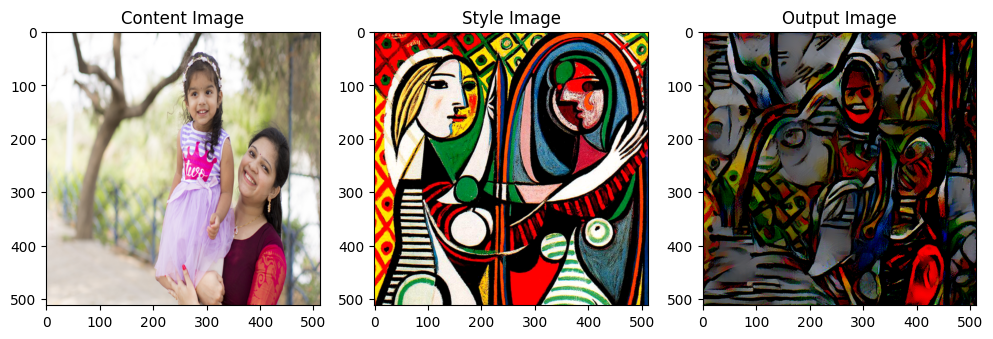

In [25]:
plt.figure(figsize=(12, 15))
plt.subplot(1, 3, 1)
plt.title('Content Image')
plt.imshow(imgs[1])
plt.subplot(1, 3, 2)
plt.title('Style Image')
plt.imshow(imgs[0])
plt.subplot(1, 3, 3)
plt.title('Output Image')
plt.imshow(out_img.permute(1, 2, 0).cpu().detach().numpy() / 255.0 )
plt.show()